In [7]:
import os
os.chdir("/Users/Chiara/Documents/Documents - Chiara’s MacBook Air/Research/YPOD Calibration/Model Improvement")
from sklearn.model_selection import train_test_split
from functools import reduce
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import numpy as np
from sklearn import metrics
import config
importlib.reload(config)
import header
importlib.reload(header)
from header import setup_plots, process_pod_data, process_reference_file, \
    impute_numeric_data, select_model, print_model_summary, plot_accuracy, \
    plot_timeseries, plot_residuals

This will look at CO and CO2 data from pods B8, A1, and U4 in the 07/09 calibration,  
Becker suggestions: add covariance and investigate nonlinear relationships so T * RH,  log, exponential, product and polynomial terms

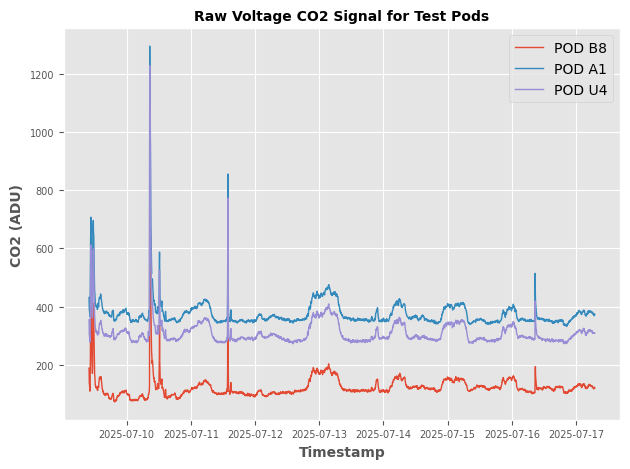

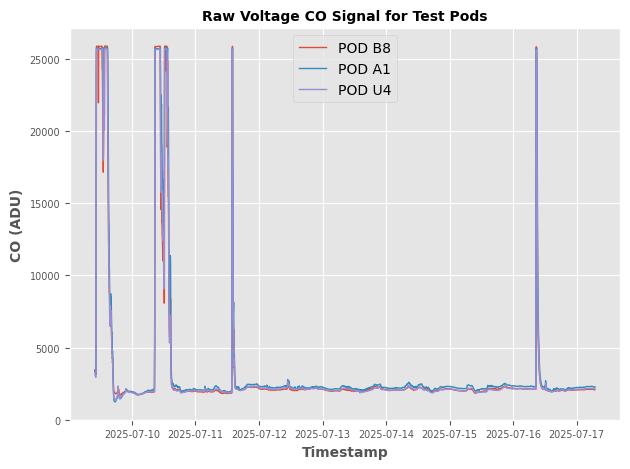

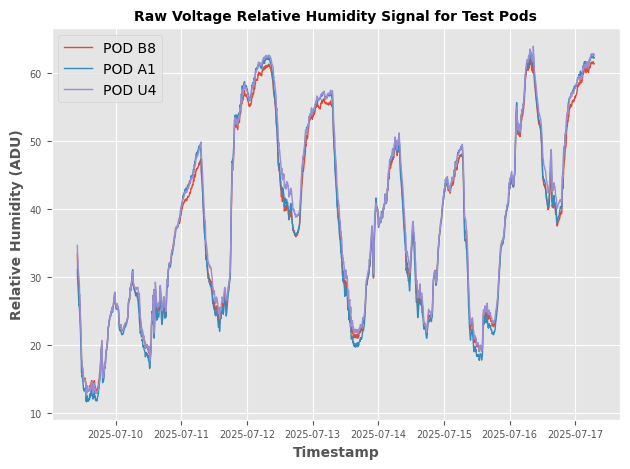

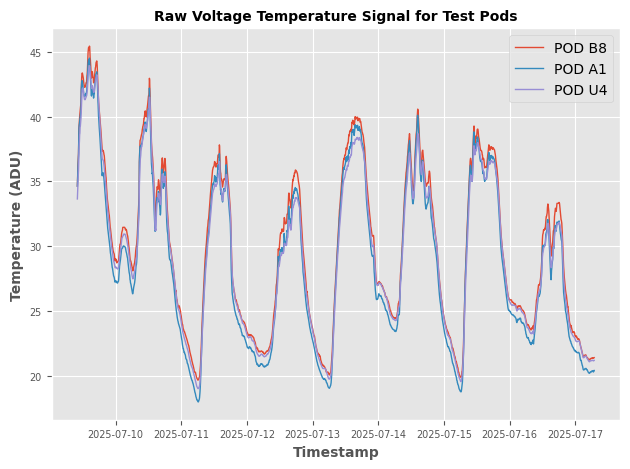

In [ ]:
ref_data_list = [process_reference_file(config.filenames[i], config.headers[i], config.row_drop[i], config.col_drop[i], config.data[i])
    for i in range(config.number_of_files)] # list for reference data df
reference_file = reduce(lambda left, right: pd.merge(left, right, on = "Timestamp", how = "outer"), ref_data_list) # merges sequentially to create one ref file
all_pod_data = [] # init

if config.raw_pod_data_plotting:
    figures, axes = setup_plots(config.pollutants)
for pod in config.pod_id:
    pod_data = process_pod_data(pod)
    all_pod_data.append(pod_data)
    if config.raw_pod_data_plotting:
        for pollutant in config.pollutants:
            axes[pollutant].plot(pod_data["Timestamp"], pod_data[pollutant], label = f"POD {pod}", linewidth = 1)
if config.raw_pod_data_plotting:
    for pollutant in config.pollutants:
        ax = axes[pollutant]
        ax.set_xlabel("Timestamp", fontweight = "bold", fontsize = 10)
        ax.set_ylabel(f"{pollutant} (ADU)", fontweight = "bold", fontsize = 10)
        ax.set_title(f"Raw Voltage {pollutant} Signal for Test Pods", fontweight = "bold", fontsize = 10)
        ax.legend(labelcolor = "black")
        ax.tick_params(axis = "x", labelsize = 7)
        ax.tick_params(axis = "y", labelsize = 7)
        figures[pollutant].tight_layout()
        if config.save_plots:
            filename = f"{pollutant.replace('.', '_')}_test_pods.png"
            path = os.path.join(config.save_dir, filename)
            figures[pollutant].savefig(path, dpi = 300)
            print(f"Saved: {path}")
    plt.show()

In [9]:
### will store dataframe for each reference instrument
reference_file = None

### for loop to iterate through refernce files and import, format data
for index in range(config.number_of_files) :
    
    ### reading in reference file, adding headers to dataframe
    ref_data = pd.read_csv(config.filenames[index])
    ref_data.columns = config.headers[index]
    ref_data.head()
    ref_data.drop(ref_data.head(config.row_drop[index]).index, inplace = True) # gets rid of unneeded rows

    ### formatting timestamps to datetime, cropping dataframe to data window of interest
    ref_data["Timestamp"] = pd.to_datetime(ref_data["Timestamp"], format = "mixed")
    ref_data = ref_data[ref_data["Timestamp"] >= config.start_cutoff] # deletes all cells before start cutoff
    ref_data = ref_data[ref_data["Timestamp"] < config.end_cutoff] # deletes all cells after end cutoff
    ref_data = ref_data.drop(labels = config.col_drop[index], axis = 1) # deletes unused columns
    ### converts calibration data to numeric values for use in .resample
    
    for columns in config.data[index] :
        ref_data[columns] = pd.to_numeric(ref_data[columns], errors = "coerce") # converts to numeric values
        ref_data.loc[ref_data[columns] == 99999, columns] = np.nan  # replaces 99999 with NaN
        ref_data.loc[ref_data[columns] < 0, columns] = 0 # sets all negativer values to zero

    ref_data.set_index("Timestamp", inplace = True) # modifies dataframe directly
    ref_data = ref_data.resample(config.sample_time).mean().reset_index() # resamples / bins at the appropriate rate
    ref_data.fillna(ref_data.mean(numeric_only = True), inplace = True) # replaces NaN values with mean of adjacent points
    
    ### creates a single reference file with all rederence data needed
    if reference_file is None :
        reference_file = ref_data ### creates reference file
    else:
        reference_file = pd.merge(reference_file, ref_data, on = "Timestamp", how = "outer") # merges all the reference data

Pod YPODB8 CO2 Testing model:

Coefficients:
CO2: 1.24884
Relative Humidity: -1.01742
Temperature: -3.14352
Intercept: 270.58603


R-squared: 0.87965
Mean absolute error: 11.10426
Mean squared error: 203.92811
Root mean squared error: 14.28034



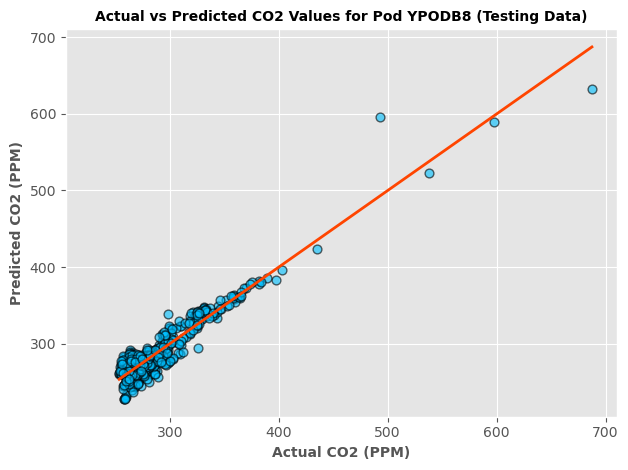

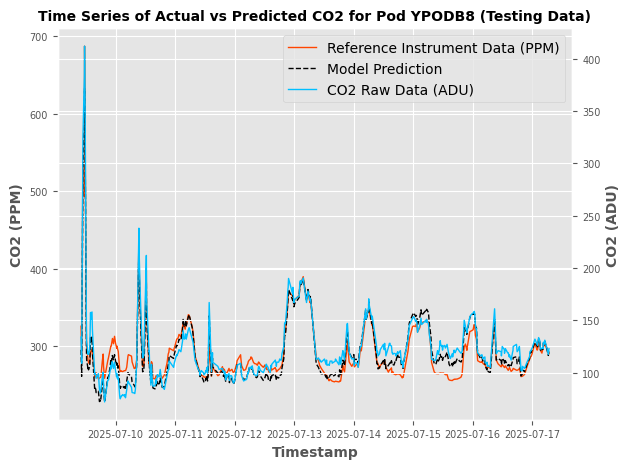

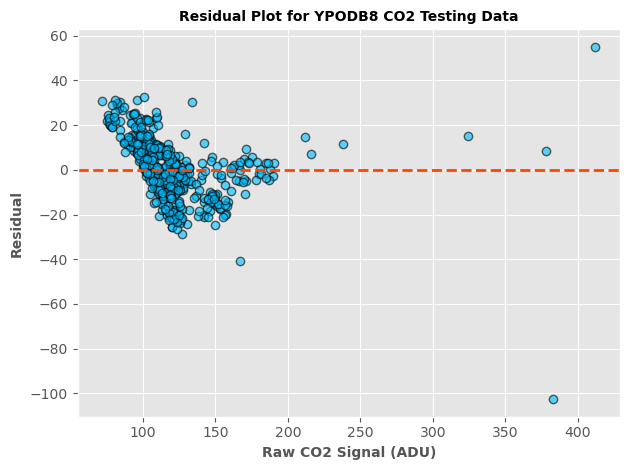

Pod YPODA1 CO2 Testing model:

Coefficients:
CO2: 1.11822
Relative Humidity: 0.01066
Temperature: -0.80076
Intercept: -105.87348


R-squared: 0.90635
Mean absolute error: 7.07676
Mean squared error: 158.67558
Root mean squared error: 12.59665



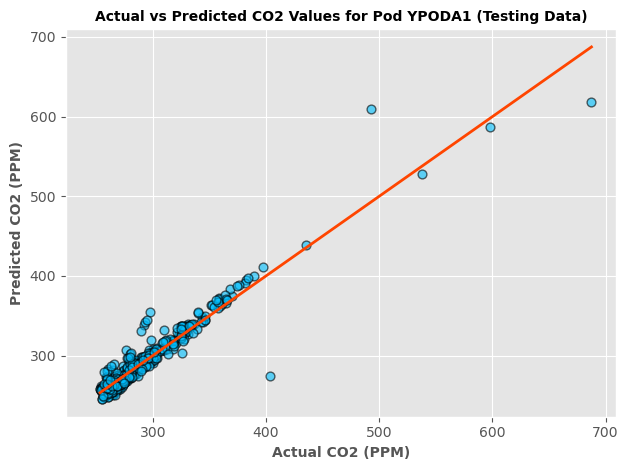

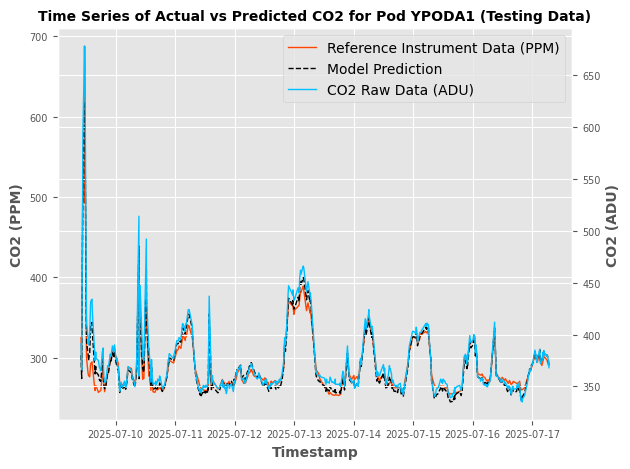

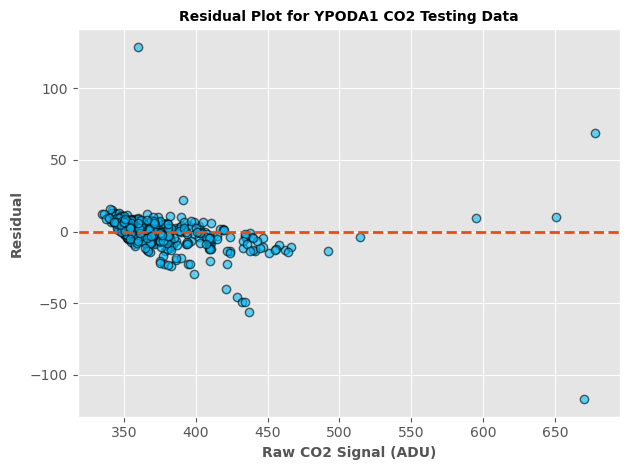

Pod YPODU4 CO2 Testing model:

Coefficients:
CO2: 1.16114
Relative Humidity: 0.18963
Temperature: 0.11822
Intercept: -79.14927


R-squared: 0.94030
Mean absolute error: 7.07139
Mean squared error: 101.15630
Root mean squared error: 10.05765



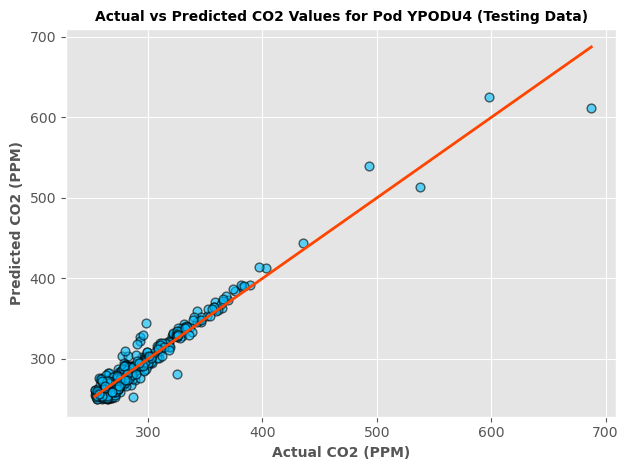

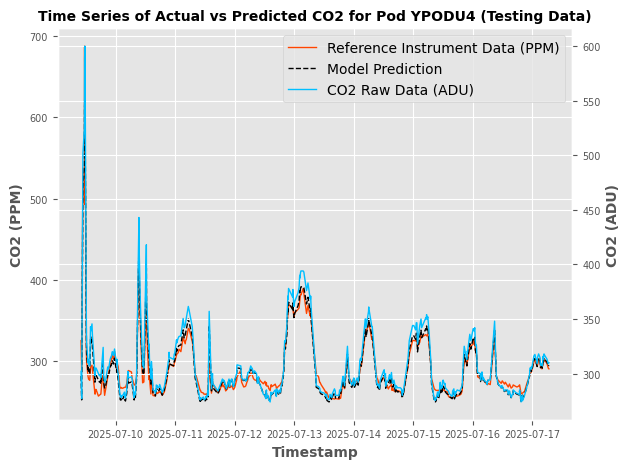

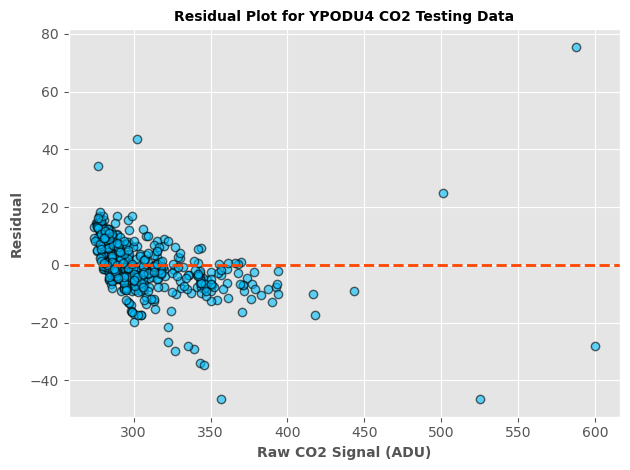

Pod YPODB8 CO Testing model:

Coefficients:
CO: 0.00107
Relative Humidity: -0.03616
Temperature: 0.22943
Intercept: -5.54088


R-squared: 0.92799
Mean absolute error: 0.61655
Mean squared error: 3.26886
Root mean squared error: 1.80800



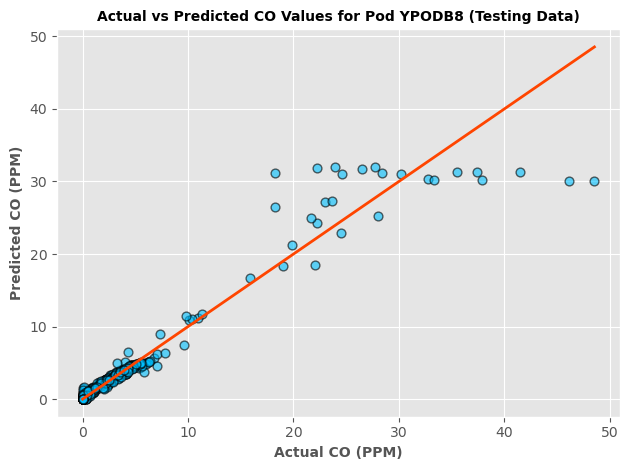

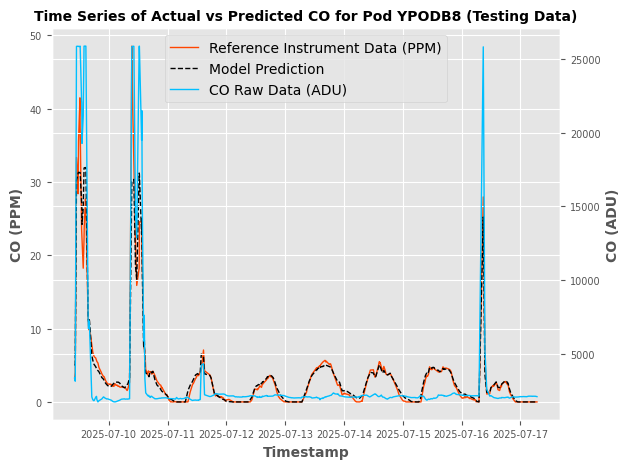

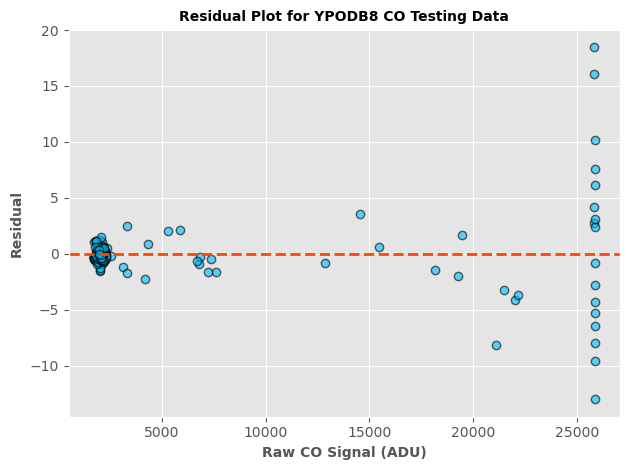

Pod YPODA1 CO Testing model:

Coefficients:
CO: 0.00099
Relative Humidity: -0.04243
Temperature: 0.21218
Intercept: -4.55454


R-squared: 0.83125
Mean absolute error: 0.75973
Mean squared error: 7.66000
Root mean squared error: 2.76767



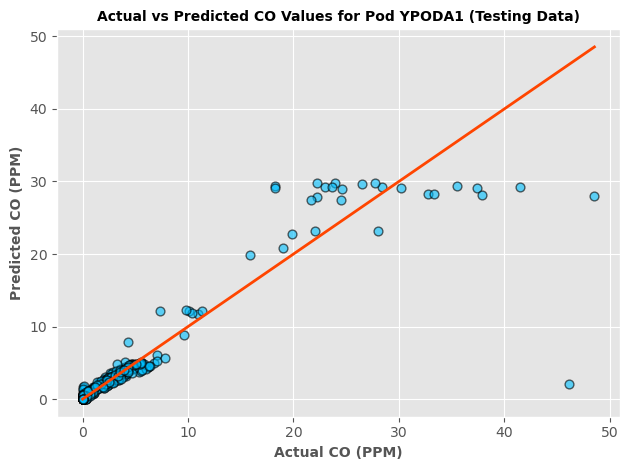

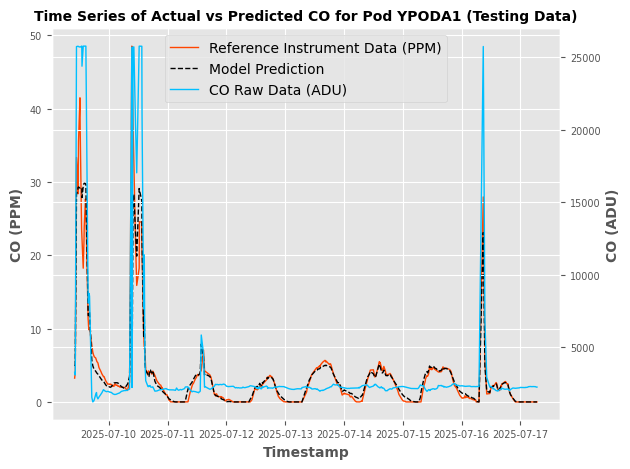

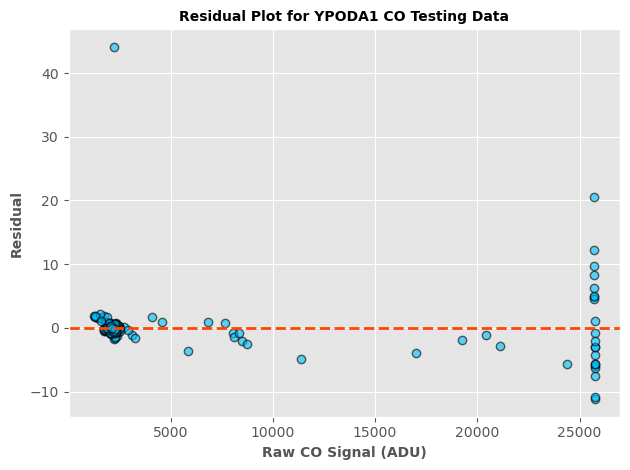

Pod YPODU4 CO Testing model:

Coefficients:
CO: 0.00104
Relative Humidity: -0.03312
Temperature: 0.25552
Intercept: -6.16986


R-squared: 0.92120
Mean absolute error: 0.63937
Mean squared error: 3.57710
Root mean squared error: 1.89132



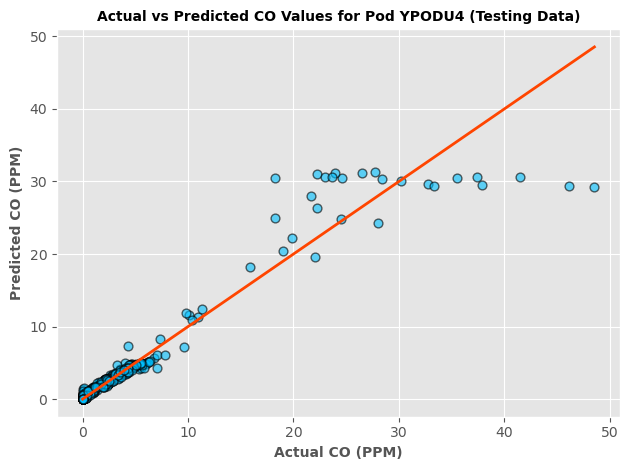

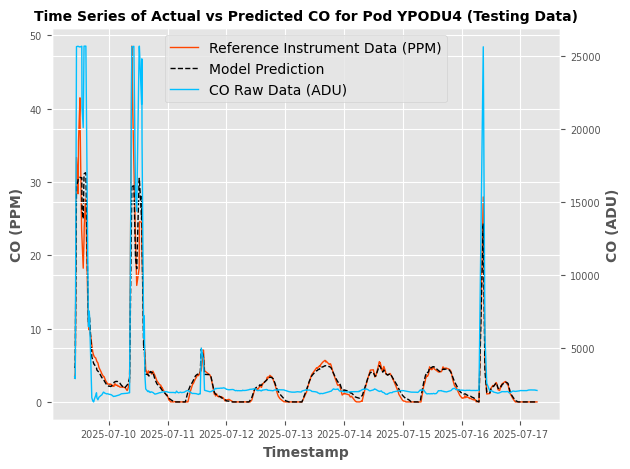

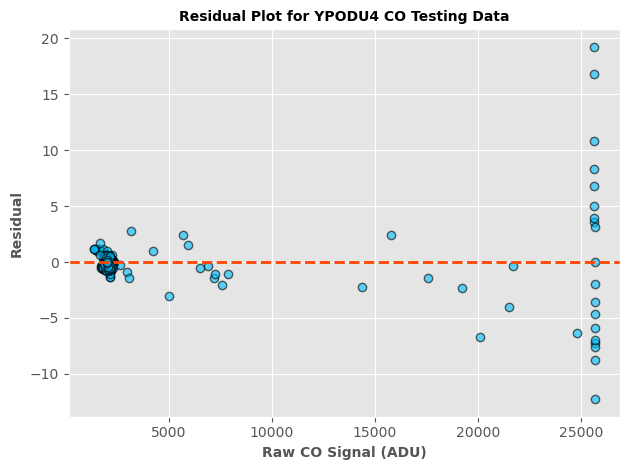

In [10]:
for model_name, ref_var, variables, units in zip(config.models, config.ref_cal_var, config.regr_var, config.calibrated_units):
    for pod in all_pod_data:
        # ****************************************************************
        # ****************************************************************
        pod_id_index = pod.iat[0, 12] # pod ID location in dataframe (last index)
        # ****************************************************************
        # ****************************************************************
        pod_imputed = impute_numeric_data(pod) # imputes pod to make numeric, get rid of nan
        y = reference_file[[ref_var, "Timestamp"]].copy() # copy
        # Merge on Timestamp to align data
        pod_imputed["Timestamp"] = pod["Timestamp"] # sets timestamps equal
        merged = pd.merge(pod_imputed[variables + ["Timestamp"]], y, on = "Timestamp", how = "inner").dropna() # merges to df
        if len(merged) == 0:
            print(f"No overlapping timestamps for Pod {pod_id_index} and reference data {model_name}")
            continue
        X = merged[variables] # picks out var from data
        y = merged[ref_var] # picks out var from reference
        regr = select_model(X, y) # selects regression model
        if regr is None:
            continue # UI
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) # 20% testing 80% training split
        regr.fit(X_train, y_train) # fits data
        yTrain_pred = np.clip(regr.predict(X_train), 0, None) # predicteed values for training data
        yTest_pred = np.clip(regr.predict(X_test), 0, None) # predicteed values for testing data
        r2Train = metrics.r2_score(y_train, yTrain_pred) # r2 for train
        r2Test = metrics.r2_score(y_test, yTest_pred) # r2 for test
        # print_model_summary(regr, variables, pod_id_index, model_name, r2Train, y_train, yTrain_pred, Type = "Training") # training model summary
        print_model_summary(regr, variables, pod_id_index, model_name, r2Test, y_test, yTest_pred, Type = "Testing") # testing model summary
        if config.model_accuracy_plotting:
            # plot_accuracy(y_train, yTrain_pred, model_name, units, pod_id_index, Type = "Training") # training
            plot_accuracy(y_test, yTest_pred, model_name, units, pod_id_index, Type = "Testing") # testing
        if config.model_timeseries_plotting:
            # plot_timeseries(X_train, y_train, yTrain_pred, pod, model_name, units, pod_id_index, Type = "Training") # training
            plot_timeseries(X_test, y_test, yTest_pred, pod, model_name, units, pod_id_index, Type = "Testing") # testing
        if config.residual_plotting:
            # plot_residuals(X_train, y_train, yTrain_pred, model_name, pod_id_index, Type = "Training")
            plot_residuals(X_test, y_test, yTest_pred, model_name, pod_id_index, Type = "Testing")
